### Importing Libraries

In [60]:
import sagemaker
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [38]:
try :
    import awswrangler as wr
    print('wrangler imported')
except :
    print('wrangler installing..')
    !pip install awswrangler --quiet
    import awswrangler as wr
    print('wrangler imported')

wrangler imported


After preprocessing the data in Athena, the queried data is stored back in S3 in parquet format. 

SQL Query :
<pre><code>
UNLOAD (
SELECT 
    email_id,
    email as email_address,
    -- date_format(event_time, '%Y-%m-%d') as event_date,
    HOUR(event_time) as event_hour,
    CASE
        WHEN tb_email_events.type IN (1,13) then 'Click'
        WHEN tb_email_events.type IN (3,14) then 'Send'
        ELSE 'Others'
    END AS event_type,
    COUNT(*) as email_count
FROM tb_email_events
WHERE date_format(event_time, '%Y-%m-%d') >= '2022-10-01'
AND date_format(event_time, '%Y-%m-%d') <= '2023-03-31'
AND type IN (1,3,13,14)
GROUP BY 1,2,3,4
) TO 's3://emailstoproject/athena_query_results/20221001-20230331/' WITH (format = 'PARQUET')

</code></pre>

The stored data is retrieved in sagemaker instance as a dataframe for modelling.

If required to re-run the analysis for other timeframe, it can be done within 10-15 minutes

### Importing Dataset

In [46]:
# directories 

bucket_name = 'emailstoproject'
base_dir = 's3://emailstoproject/'
output_dir = 's3://emailstoproject/sto_email_output/'

# data path
path = 's3://emailstoproject/athena_query_results/20221001-20230331/'

# read parquet file using S3 wrangler
df = wr.s3.read_parquet(path, dataset=True)

# print data overview
print("Email Send & Click Event from Oct 01 2022 to Mar 31 2023")
print("Total Number of Rows : {}".format(len(df)))
print("Total Number of Distinct Emails : {}".format(df.email_id.nunique()))

Email Send & Click Event from Oct 01 2022 to Mar 31 2023
Total Number of Rows : 13994699
Total Number of Distinct Emails : 1326920


### Preprocessing & EDA

In [47]:
# using dictionary to convert specific column datatypes
convert_dict = {'email_id': int,
                'email_address': str,
                'event_hour' : int,
                'event_type' : str,
                'email_count' : int
                }
df = df.astype(convert_dict)

# filtering send and click stats into seperate dataframe
df_send = df[df.event_type == 'Send']
df_click = df[df.event_type == 'Click']

In [53]:
df_send.sample(1, random_state=10)

,email_id,email_address,event_hour,event_type,email_count
140902,24497,taknight123@gmail.com,21,Send,2


In [54]:
df_click.sample(1, random_state=10)

,email_id,email_address,event_hour,event_type,email_count
254393,2087794,81nam@fuse.net,14,Click,3


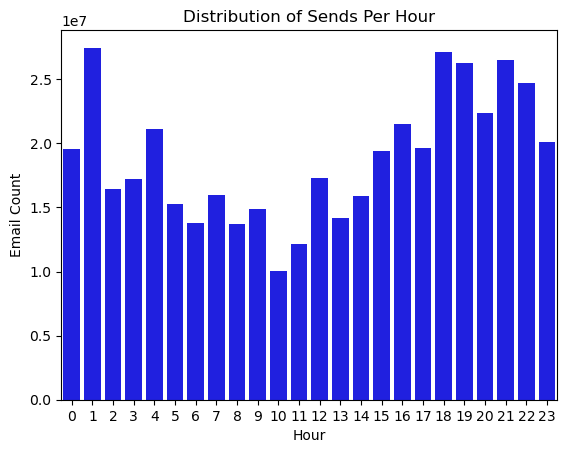

In [64]:
send_agg_stat = pd.DataFrame(df_send.groupby(by='event_hour').sum()['email_count']).reset_index()

ax = sns.barplot(x = 'event_hour',y = 'email_count',data = send_agg_stat, 
                 errwidth=0, orient='v', color='b')

ax.set_title('Distribution of Sends Per Hour')
ax.set_xlabel('Hour')
ax.set_ylabel('Email Count')
plt.show()

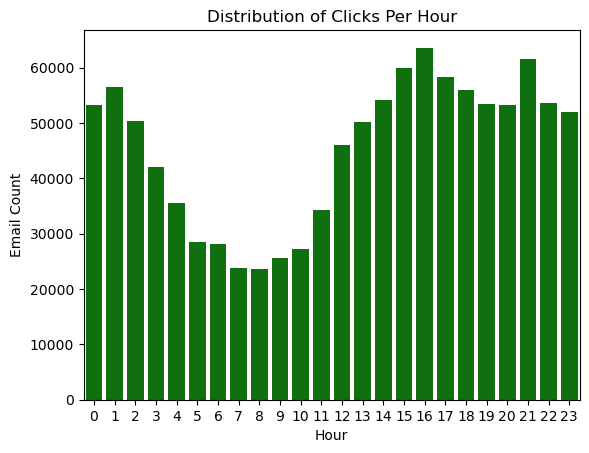

In [65]:
click_agg_stat = pd.DataFrame(df_click.groupby(by='event_hour').sum()['email_count']).reset_index()

ax = sns.barplot(x = 'event_hour',y = 'email_count',data = click_agg_stat, 
                 errwidth=0, orient='v', color='g')

ax.set_title('Distribution of Clicks Per Hour')
ax.set_xlabel('Hour')
ax.set_ylabel('Email Count')
plt.show()

### Modelling Our Email Send Time Optimisation

#### Background : 

Ultimate deliverable will be to generate results for STO of each email_id by their time bucket ranked according to CTR ( Click / Sent * 100) and open rate ( Open / Sent * 100 ) 

#### Output Format : 

![Output Format](output.png)

To explain, User A has the best click rate at 15 th hour of the day. 

**Click Per Bucket Dataframe**

Objective is to create a pivot table from click stats, taking unique *email_id* as row and *event_hour* as the pivot/columns. The measure of our pivot table will be *email_count* which we'll aggregate(sum) for the respective row and pivot.

In [78]:
# click per bucket pivot table 

df_cpb = pd.pivot_table(df_click, values='email_count', index='email_id', 
                            columns='event_hour', aggfunc=np.sum, 
                            margins=True, margins_name='Total')

df_cpb = df_cpb.fillna(0)                            # remove NaNs with 0
df_cpb = df_cpb.astype(int).reset_index()             # pivot table to dataframe

# sorting stats by most sends
df_cpb = df_cpb.iloc[:-1 , :].sort_values(by='Total', ascending=False)

In [80]:
df_cpb.sample(1, random_state=10)

event_hour,email_id,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,Total
74735,2262304,0,0,0,0,0,0,1,5,1,...,0,1,0,0,0,0,0,0,0,8


**Send Per Bucket DataFrame**

Objective is alike of click per bucket dataframe

In [81]:
# Sends per bucket pivot table 

df_spb = pd.pivot_table(df_send, values='email_count', index='email_id', 
                            columns='event_hour', aggfunc=np.sum, 
                            margins=True, margins_name='Total')

df_spb = df_spb.fillna(0)
df_spb = df_spb.astype(int).reset_index()

#sorting
df_spb = df_spb.iloc[:-1 , :].sort_values(by='Total', ascending=False)

In [82]:
df_spb.sample(1, random_state=10)

event_hour,email_id,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,Total
717830,1045633,3,7,4,7,19,7,8,8,6,...,5,6,5,9,4,6,22,5,4,190


**Calculating CTR per Bucket**

We formulate the CTR based on the total email sent vs clicked . We do so by dividing click by send across each bucket and calculating percentage.


In [84]:
# format to percentage custom function

def format_pct(x):
    return '{:.2%}'.format(x) 

In [86]:
# merge click per hour stats with send per hour 
ctr = pd.merge(df_cpb,df_spb[['email_id','Total']], how='inner', on='email_id')


ctr = ctr.rename(columns={'Total_x':'total_click', 'Total_y':'total_send'})
ctr.iloc[:,1:-1]= ctr.iloc[:,1:-1].div(ctr.total_send, axis=0).apply(lambda x:x)

In [88]:
# function to sort a row and get the list of all columns in the ranked order

def get_sorted_cols(row):
    sorted_row = row.sort_values(ascending=False)
    sorted_row = sorted_row.astype(int)
    sorted_cols = sorted_row.index.tolist()
    return sorted_cols

In [89]:
# delete previous columns

cols_to_drop = []
for i in range(24):
    cols_to_drop.append(i)

In [92]:
ctr_output = ctr.copy()

# get the list of ranks in a column
ctr_output['data'] = ctr_output.iloc[:, 1:-2].apply(lambda x: get_sorted_cols(x), axis=1)

# drop previous columns
ctr_output = ctr_output.drop(columns=cols_to_drop)

# spread the list of ranks across the dataframe
ctr_output = pd.concat([ctr_output.drop(['data'], axis=1), ctr_output['data'].apply(pd.Series)], axis=1)
ctr_output['total_click'] = ctr_output['total_click'].apply(format_pct)
ctr_output = ctr_output.rename(columns= {'total_click' : 'click_perc'})

#rename the columns
ctr_output.columns = ['Top ' + str(int(c) + 1) if str(c).isdigit() else c for c in ctr_output.columns]

# create an email map from click events data
email_map = df_click[['email_id', 'email_address']].drop_duplicates()
email_map = email_map[email_map.email_id != 0]

# map the email_id with email_address
ctr_output['email_address'] = ctr_output['email_id'].map(email_map.set_index('email_id')['email_address'])

# output saved
output_brief = ctr_output[['email_address','email_id','total_send', 'click_perc']]

sto_output = ctr_output[['email_address', 'Top 1', 'Top 2', 'Top 3',
       'Top 4', 'Top 5', 'Top 6', 'Top 7', 'Top 8', 'Top 9', 'Top 10',
       'Top 11', 'Top 12', 'Top 13', 'Top 14', 'Top 15', 'Top 16', 'Top 17',
       'Top 18', 'Top 19', 'Top 20', 'Top 21', 'Top 22', 'Top 23', 'Top 24']]


print("Modelling Complete")

Modelling Complete


### Visualizing the Outputs

In [93]:
sto_output.sample(2, random_state=10)

,email_address,Top 1,Top 2,Top 3,Top 4,Top 5,Top 6,Top 7,Top 8,Top 9,...,Top 15,Top 16,Top 17,Top 18,Top 19,Top 20,Top 21,Top 22,Top 23,Top 24
91430,bobnruth@bellsouth.net,4,0,13,22,21,20,19,18,17,...,11,10,9,8,7,6,5,3,2,23
88492,terrybenson@cox.net,15,0,1,22,21,20,19,18,17,...,10,9,8,7,6,5,4,3,2,23


### Verification

In [94]:
pd.set_option('display.max_columns', None)

In [98]:
# email_id : 2318667
# email_address : 'kay@cfu.net'

print("Email Send To This Subscriber Per Bucket")
df_spb[df_spb.email_id == 2318667]

Email Send To Subscriber Per Bucket


event_hour,email_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,Total
1202808,2318667,53,72,57,31,53,24,24,47,35,41,29,34,59,45,44,56,71,61,72,75,78,57,64,42,1224


In [99]:
print("Email Clicked By This Subscriber Per Bucket")
df_cpb[df_cpb.email_id == 2318667]

Email Clicked By This Subscriber Per Bucket


event_hour,email_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,Total
95137,2318667,0,1,0,0,0,0,0,0,0,0,0,1,0,9,19,3,6,7,4,1,6,3,3,1,64


In [100]:
print("STO Optimised Bucket Output")
sto_output[sto_output.email_address == 'kay@cfu.net']

STO Optimised Bucket Output


,email_address,Top 1,Top 2,Top 3,Top 4,Top 5,Top 6,Top 7,Top 8,Top 9,Top 10,Top 11,Top 12,Top 13,Top 14,Top 15,Top 16,Top 17,Top 18,Top 19,Top 20,Top 21,Top 22,Top 23,Top 24
1827,kay@cfu.net,14,13,17,20,16,18,22,21,15,23,19,11,1,0,10,9,8,7,6,5,4,3,2,12


### Overview of STO Output

In [102]:
print("Total Send Time Optimised Emails  {}".format(sto_output.email_address.nunique()))

Total Send Time Optimised Emails  121933


Text(0.5, 0, 'Hour')

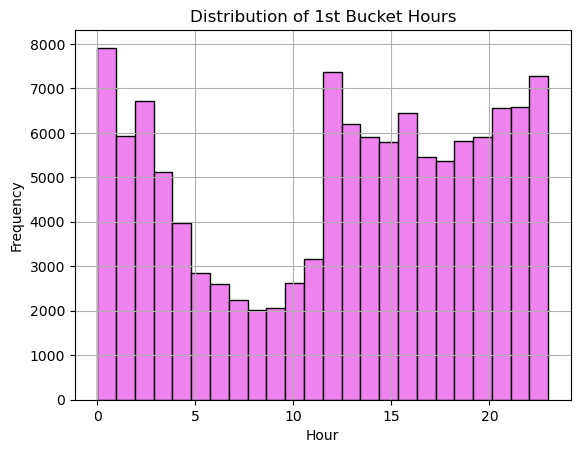

In [104]:
sto_output['Top 1'].hist(bins=24, edgecolor="black", color='violet')
plt.title("Distribution of 1st Bucket Hours")
plt.ylabel("Frequency")
plt.xlabel("Hour")

### Storing in S3

In [106]:
sto_output.to_csv('sto-email-buckets.csv', index=False)
output_brief.to_csv('sto-modelling-brief.csv', index=False)

In [111]:
# instantiate S3 client and upload to s3
import boto3

s3 = boto3.resource('s3')
s3.meta.client.upload_file('sto-email-buckets.csv', bucket_name, 'sto_email_output/sto-email-buckets.csv')

In [112]:
s3.meta.client.upload_file('sto-modelling-brief.csv', bucket_name, 'sto_email_output/sto-modelling-brief.csv')

# The End